In [263]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
plt.style.use('fivethirtyeight')


In [264]:
# DB connection
db_config = {
    "username": "root",
    "password": "root",
    "host": "localhost",
    "port": 3306,
    "database": "nhl"
}

connection_string = f"mysql+pymysql://{db_config['username']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Grab data from the db
df = pd.read_sql("""
WITH RankedGames AS (
    SELECT 
        game_date,
        home_abbrev,
        home_goals,
        home_pim,
        home_hits,
        away_abbrev,
        away_goals,
        away_pim,
        away_hits,
        (home_hits + away_hits) AS total_hits,
        (home_pim + away_pim) AS total_pim
    FROM 
        boxscores
    ORDER BY 
        total_pim DESC, total_hits DESC
    LIMIT 10
)
SELECT 
    rg.game_date,
    rg.home_abbrev, 
    rg.home_goals, 
    rg.home_pim, 
    rg.home_hits,
    rg.away_abbrev, 
    rg.away_goals, 
    rg.away_pim, 
    rg.away_hits,
    rg.total_hits,
    rg.total_pim,
    hs.teamLogo AS home_logo,
    away.teamLogo AS away_logo
FROM 
    RankedGames rg
JOIN 
    standings hs ON rg.home_abbrev = hs.teamAbbrev
JOIN 
    standings away ON rg.away_abbrev = away.teamAbbrev

""", engine)


In [265]:
# Team information, and primary and secondary colors.

Team_info = {"BOS": ("#FFB81C", "#000000"),
             "BUF": ("#003087", "#FFB81C"),
             "DET": ("#CE1126", "#FFFFFF"),
             "FLA": ("#041E42", "#B9975B"),
             "MTL": ("#AF1E2D", "#192168"),
             "OTT": ("#DA1A32", "#B79257"),
             "TBL": ("#002868", "#FFFFFF"),
             "TOR": ("#00205B", "#FFFFFF"),
             "CAR": ("#CE1126", "#000000"),
             "CBJ": ("#002654", "#CE1126"),
             "NJD": ("#CE1126", "#000000"),
             "NYI": ("#00539B", "#F47D30"),
             "NYR": ("#0038A8", "#CE1126"),
             "PHI": ("#F74902", "#000000"),
             "PIT": ("#FCB514", "#000000"),
             "WSH": ("#041E42", "#C8102E"),
             "ARI": ("#8C2633", "#E2D6B5"),
             "CHI": ("#CF0A2C", "#FF671B"),
             "COL": ("#6F263D", "#236192"),
             "DAL": ("#006847", "#8F8F8C"),
             "MIN": ("#A6192E", "#154734"),
             "NSH": ("#FFB81C", "#041E42"),
             "STL": ("#002F87", "#FCB514"),
             "WPG": ("#041E42", "#AC162C"),
             "ANA": ("#B9975B", "#F47A38"),
             "CGY": ("#D2001C", "#FAAF19"),
             "EDM": ("#041E42", "#FF4C00"),
             "LAK": ("#111111", "#A2AAAD"),
             "SJS": ("#006D75", "#EA7200"),
             "SEA": ("#001628", "#99D9D9"),
             "VAN": ("#00205B", "#041C2C"),
             "VGK": ("#B4975A", "#333F42")}

def get_colour_codes(search_key):
    search_key = search_key.upper()
    for key in Team_info:
        if key == search_key:
            primary = Team_info[key][0]
            secondary = Team_info[key][1]
    return primary, secondary

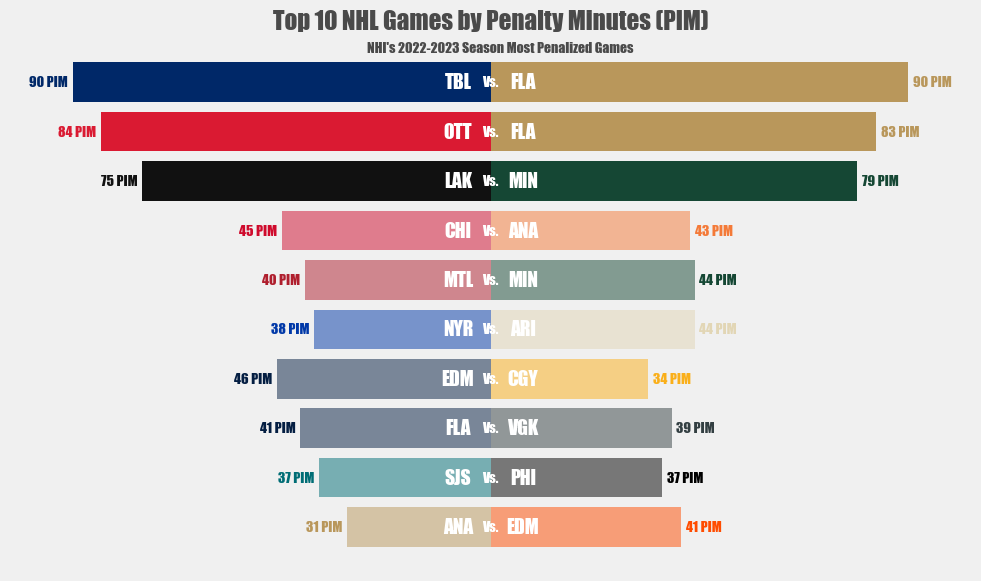

In [266]:
df_sorted = df.sort_values(by="total_pim", ascending=True).reset_index(drop=True)

max_total_pim = df_sorted['total_pim'].max()
top_3_indexes = df_sorted.index[-3:]

# Get the colors for home and away teams using the corrected function name
df_sorted['home_color'] = df_sorted['home_abbrev'].apply(lambda x: get_colour_codes(x)[0])
df_sorted['away_color'] = df_sorted['away_abbrev'].apply(lambda x: get_colour_codes(x)[1])
font_color = '#4a4a4a'
font = 'fantasy'

# Plotting the chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yticks([])
ax.set_xticks([])

# Plot bars seperating top 3 from the other games
for i, row in df_sorted.iterrows():
    # Enhance the color or use a distinct style for the top 3
    is_top_3 = i in top_3_indexes
    home_color = row['home_color']
    away_color = row['away_color']
    alpha_level = 1 if is_top_3 else 0.5 # Dim to focus on top 3

    # Home PIM Bar
    ax.barh(i, -row['home_pim'], color=home_color, alpha=alpha_level)
    # Team abbreviation
    ax.text(-7, i, row['home_abbrev'], ha='center', va='center', color='white', fontsize=14, family=font)
    ax.text(0, i, 'Vs.', ha='center', va='center', color='white', fontsize=10, family=font)
    # PIM value
    ax.text(-row['home_pim'] - 1, i, f"{row['home_pim']} PIM", ha='right', va='center', color=home_color, fontsize=10, family=font)

    # Away PIM Bar
    ax.barh(i, row['away_pim'], color=away_color, alpha=alpha_level)
    # Team abbreviation
    ax.text(7, i, row['away_abbrev'], ha='center', va='center', color='white', fontsize=14, family=font)
    # PIM value
    ax.text(row['away_pim'] + 1, i, f"{row['away_pim']} PIM", ha='left', va='center', color=away_color, fontsize=10, family=font)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(alpha = 0.2)

max_pim_value = max(df_sorted['home_pim'].max(), df_sorted['away_pim'].max())
ax.set_xlim(-max_pim_value * 1.15, max_pim_value * 1.15)


ax.set_title('Top 10 NHL Games by Penalty Minutes (PIM)', fontsize=18, color=font_color, family=font, y = 1)
ax.annotate("NHl's 2022-2023 Season Most Penalized Games", 
            xy=(0.5, 0.88), xycoords='figure fraction', ha='center', fontsize=10, color=font_color, family=font)


plt.tight_layout(pad=1)
plt.show()

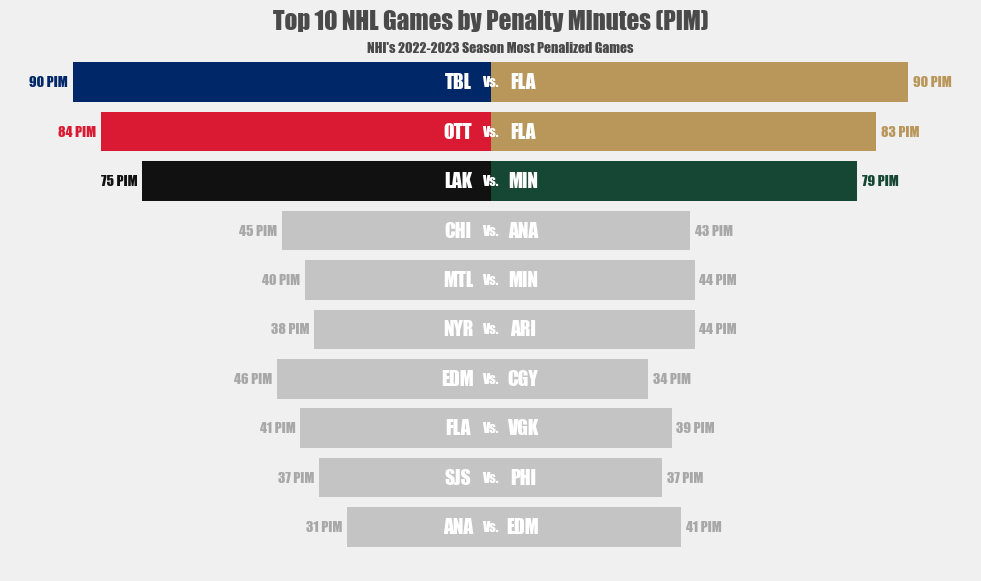

In [267]:
df_sorted = df.sort_values(by="total_pim", ascending=True).reset_index(drop=True)

max_total_pim = df_sorted['total_pim'].max()
top_3_indexes = df_sorted.index[-3:]

# Get the colors for home and away teams using the corrected function name
df_sorted['home_color'] = df_sorted['home_abbrev'].apply(lambda x: get_colour_codes(x)[0])
df_sorted['away_color'] = df_sorted['away_abbrev'].apply(lambda x: get_colour_codes(x)[1])
font_color = '#4a4a4a'
font = 'fantasy'

# Plotting the chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yticks([])
ax.set_xticks([])

# Plot bars seperating top 3 from the other games
for i, row in df_sorted.iterrows():
    # Enhance the color or use a distinct style for the top 3
    # Greyscaled, and transparent, to highlight top 3
    is_top_3 = i in top_3_indexes
    home_color = row['home_color'] if is_top_3 else '#A8A8A8' 
    away_color = row['away_color'] if is_top_3 else '#A8A8A8'
    alpha_level = 1 if is_top_3 else 0.6

    # Home PIM Bar
    ax.barh(i, -row['home_pim'], color=home_color, alpha=alpha_level)
    # Team abbreviation
    ax.text(-7, i, row['home_abbrev'], ha='center', va='center', color='white', fontsize=14, family=font)
    ax.text(0, i, 'Vs.', ha='center', va='center', color='white', fontsize=10, family=font)
    # PIM value
    ax.text(-row['home_pim'] - 1, i, f"{row['home_pim']} PIM", ha='right', va='center', color=home_color, fontsize=10, family=font)

    # Away PIM Bar
    ax.barh(i, row['away_pim'], color=away_color, alpha=alpha_level)
    # Team abbreviation
    ax.text(7, i, row['away_abbrev'], ha='center', va='center', color='white', fontsize=14, family=font)
    # PIM value
    ax.text(row['away_pim'] + 1, i, f"{row['away_pim']} PIM", ha='left', va='center', color=away_color, fontsize=10, family=font)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(alpha = 0.2)

max_pim_value = max(df_sorted['home_pim'].max(), df_sorted['away_pim'].max())
ax.set_xlim(-max_pim_value * 1.15, max_pim_value * 1.15)


ax.set_title('Top 10 NHL Games by Penalty Minutes (PIM)', fontsize=18, color=font_color, family=font, y = 1)
ax.annotate("NHl's 2022-2023 Season Most Penalized Games", 
            xy=(0.5, 0.88), xycoords='figure fraction', ha='center', fontsize=10, color=font_color, family=font)


plt.tight_layout(pad=1)
plt.show()

#### Found an absolutely wild game with 180 total penalty minutes, between the Florida Panthers and Tampa Bay Lightning.

See the game details here: https://www.espn.com/nhl/game/_/gameId/401560083/panthers-lightning

In [268]:
df = pd.read_sql("""
SELECT  
    homeWins,
    roadWins,
    teamAbbrev,
    (homeGamesPlayed + roadGamesPlayed) AS total_games,
    points
FROM 
    standings
""", engine)

In [269]:
# Creating a test to test if teams win more or less when at home.

def test_significance(row):
    count = np.array([row['homeWins'], row['roadWins']])
    nobs = np.array([row['total_games'] / 2, row['total_games'] / 2])
    stat, pval = proportions_ztest(count, nobs, alternative='two-sided')
    return pval

df['pValue'] = df.apply(test_significance, axis=1)

df['significant_difference'] = df['pValue'] < 0.05

df

,homeWins,roadWins,teamAbbrev,total_games,points,pValue,significant_difference
0,26,22,NYR,72,100,0.317311,False
1,22,23,DAL,73,99,0.809788,False
2,23,19,BOS,73,99,0.343565,False
3,24,21,VAN,72,98,0.465209,False
4,21,25,FLA,72,97,0.326379,False
5,28,18,COL,72,97,0.014144,True
6,24,21,CAR,73,97,0.470233,False
7,23,21,WPG,72,94,0.628745,False
8,23,20,EDM,70,90,0.461342,False
9,21,22,NSH,72,90,0.810107,False


Chicago and Colorado win significantly more at home, rather than on the road!

It is interesting to see this happening to a team who near the top of the standings and Chicago, who is near the bottom.

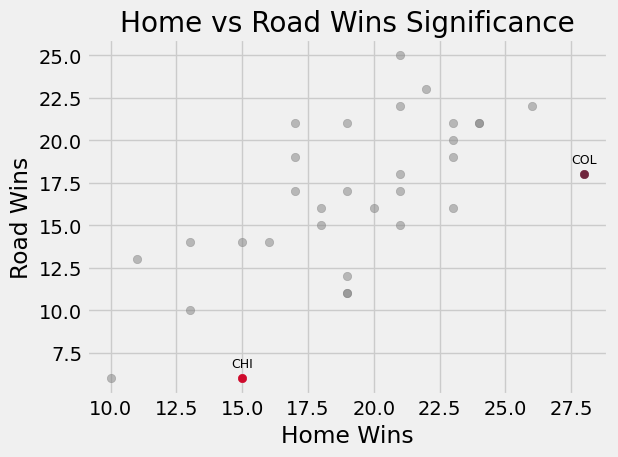

In [280]:
# Get Color Codes for Chart
df['color'] = df['teamAbbrev'].apply(lambda x: get_colour_codes(x)[0])

font_color = '#4a4a4a'
font = 'fantasy'

fig, ax = plt.subplots()

# Scatter plot for teams who don't preform significantly different when home and away.
non_significant_mask = ~df['significant_difference']
ax.scatter(df.loc[non_significant_mask, 'homeWins'], 
           df.loc[non_significant_mask, 'roadWins'], 
           color='grey', alpha=0.5, label='Not Significant')

# Scatter plot for teams who preform significantly different when home and away.
significant_mask = df['significant_difference']
for _, row in df[significant_mask].iterrows():
    ax.scatter(row['homeWins'], row['roadWins'], color=row['color'])
    # Adding text annotation for team abbreviation slightly above the point
    ax.text(row['homeWins'], row['roadWins'] + 0.5, row['teamAbbrev'], 
            ha='center', va='bottom', color='black', fontsize=9)

plt.xlabel('Home Wins')
plt.ylabel('Road Wins')
plt.title('Home vs Road Wins Significance')


plt.tight_layout()
plt.show()
